In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
good_data=pd.read_csv('./export_dataframe.csv')
good_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
1,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
2,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
3,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
4,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1


Class Split
1    132
0     96
Name: target, dtype: int64


Text(0, 0.5, 'Count')

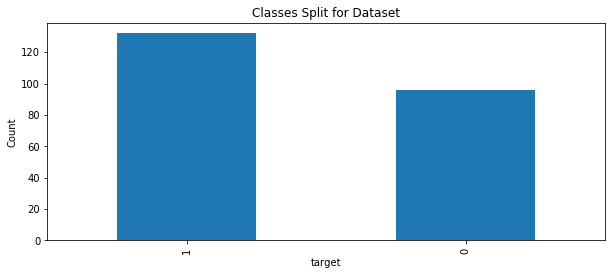

In [3]:
#Class Balance
print('Class Split')
print(good_data['target'].value_counts())
good_data['target'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('target')
plt.ylabel('Count')

In [4]:
#Create x and y variables
x = good_data.drop(['target', 'restecg', 'fbs', 'chol'], axis=1).values
Y = good_data['target'].values

#Create Training Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.fit_transform(x_test)

#Import Model
from sklearn.ensemble import ExtraTreesClassifier

In [5]:
#Class Balance - Test Data
print('Train Data - Class Split')
best= (y_train_smt == 0).sum()
rec = (y_train_smt == 1).sum()
print('Class 0 -',  best)
print('Class 1 -',  rec)

Train Data - Class Split
Class 0 - 105
Class 1 - 105


In [6]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_et = Pipeline([('scl', StandardScaler()),
                    ('clf', ExtraTreesClassifier(n_estimators=100,random_state=100))])
pipeline.insert(0,pipe_et)


# Set grid search params 

modelpara =[]
param_gridet = {
            'clf__n_estimators': [100,150,200],
            'clf__max_features': ['auto', 'log2', 'sqrt'],
            'clf__bootstrap': [True, False]}
modelpara.insert(0,param_gridet)

In [7]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train2, 
                                                            y=y_train_smt,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',
                                                            n_jobs=1,random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()


Extra Trees - Learning Curve


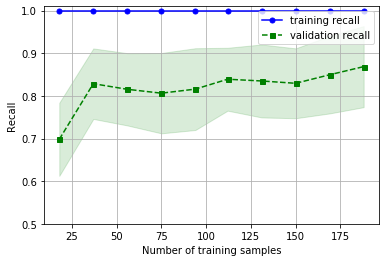

In [8]:
#Plot Learning Curve
print('\nExtra Trees - Learning Curve')
plot_learning_curves(pipe_et)

Model Evaluation - Recall Weighted
Extra Trees 0.84 +/- 0.08




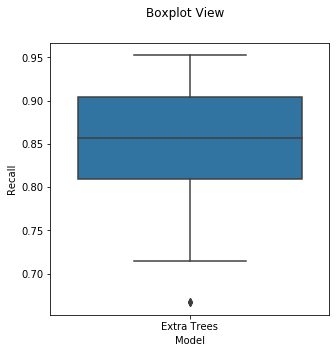

In [9]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Extra Trees',pipe_et))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Weighted')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train2,y_train_smt,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()


Optimized Model

Model Name: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=100, verbose=0,
                     warm_start=False)

Best Parameters: {'clf__bootstrap': True, 'clf__max_features': 'auto', 'clf__n_estimators': 150}

 [[17  2]
 [ 6 21]]

               precision    recall  f1-score   support

   Outcome 0       0.74      0.89      0.81        19
   Outcome 1       0.91      0.78      0.84        27

    accuracy                           0.83        46
   macro avg       0.83      0.84      0.82        46
weighted avg       0.84      0.83      0.83        46


NestedCV Accuracy(weighted) :0.84 +/-0.06 
N

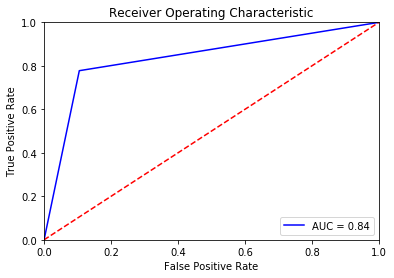

In [10]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=1, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train2, y_train_smt)
    model = gs_clf.best_estimator_
    
    #Nested CV
    x_2 = sc.fit_transform(x)
    scoreACC = cross_val_score(gs_clf, x_2, Y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreRM),np.std(scoreRM)))
    print('\n')
    
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

In [11]:
#Create x and y variables
x = good_data.drop(['target', 'exang', 'thalach', 'restecg', 'fbs', 'chol', 'trestbps', 'age'], axis=1).values
Y = good_data['target'].values

#Create Training Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.fit_transform(x_test)

#Import Model
from sklearn.ensemble import ExtraTreesClassifier

In [12]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_et = Pipeline([('scl', StandardScaler()),
                    ('clf', ExtraTreesClassifier(n_estimators=100,random_state=100))])
pipeline.insert(0,pipe_et)


# Set grid search params 

modelpara =[]
param_gridet = {
            'clf__n_estimators': [100,150,200],
            'clf__max_features': ['auto', 'log2', 'sqrt'],
            'clf__bootstrap': [True, False]}
modelpara.insert(0,param_gridet)

In [13]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train2, 
                                                            y=y_train_smt,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',
                                                            n_jobs=1,random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()


Extra Trees - Learning Curve


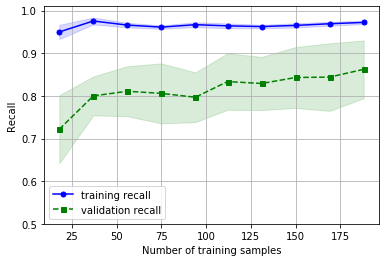

In [14]:
#Plot Learning Curve
print('\nExtra Trees - Learning Curve')
plot_learning_curves(pipe_et)

Model Evaluation - Recall Weighted
Extra Trees 0.84 +/- 0.07




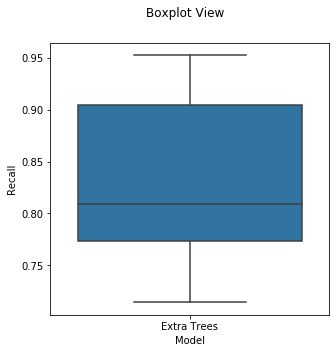

In [15]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Extra Trees',pipe_et))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Weighted')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train2,y_train_smt,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()


Optimized Model

Model Name: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=100, verbose=0,
                     warm_start=False)

Best Parameters: {'clf__bootstrap': True, 'clf__max_features': 'auto', 'clf__n_estimators': 100}

 [[15  4]
 [ 4 23]]

               precision    recall  f1-score   support

   Outcome 0       0.79      0.79      0.79        19
   Outcome 1       0.85      0.85      0.85        27

    accuracy                           0.83        46
   macro avg       0.82      0.82      0.82        46
weighted avg       0.83      0.83      0.83        46


NestedCV Accuracy(weighted) :0.82 +/-0.04 
N

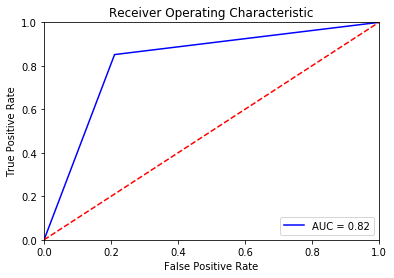

In [16]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=1, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train2, y_train_smt)
    model = gs_clf.best_estimator_
    
    #Nested CV
    x_2 = sc.fit_transform(x)
    scoreACC = cross_val_score(gs_clf, x_2, Y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreRM),np.std(scoreRM)))
    print('\n')
    
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)